In [1]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from IPython.display import display, Latex
from sklearn.cluster import KMeans

from utils.data_management import check_constraints, load_data
from utils import regularization_benefit, cross_lambda_training
from utils.visualization import plot_codings_lamb, plot_rro

from models import model_selection
from models import DictionaryLearning

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.ar_model import AutoReg

from datetime import date, timedelta

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import IFrame
%load_ext autoreload
%autoreload 2

ImportError: cannot import name 'regularization_benefit' from 'utils' (/Users/michaelallouche/PhD/repos/dictionary-learning-rmm/dictionary-learning-RMM/utils/__init__.py)

# Data

In [2]:
P = load_data()
pd.DataFrame(P)

,0,1,2,3,4,5,6,7,8,9,...,182,183,184,185,186,187,188,189,190,191
0,0.767199,0.767205,0.736855,0.748747,0.748338,0.771916,0.756948,0.904350,0.903882,0.903974,...,0.832057,0.803909,0.810724,0.767708,0.772607,0.766515,0.749932,0.734179,0.763076,0.778180
1,0.050118,0.055954,0.054800,0.052730,0.052412,0.063683,0.042119,0.041471,0.049926,0.048222,...,0.007518,0.007206,0.000000,0.001292,0.001327,0.001332,0.001248,0.001245,0.001239,0.000000
2,0.000561,0.000547,0.001595,0.001563,0.001525,0.014756,0.013023,0.012899,0.012411,0.012479,...,0.002459,0.000652,0.000641,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,0.006975,0.006991,0.006832,0.006331,0.006306,0.006298,0.000000,0.000000,0.000000,0.000000,...,0.003521,0.003357,0.003591,0.002997,0.002923,0.002934,0.002941,0.003057,0.003068,0.002039
106,0.006737,0.006714,0.006634,0.007171,0.007151,0.007044,0.009697,0.004770,0.004725,0.004799,...,0.005506,0.004808,0.004692,0.004769,0.005557,0.007287,0.003980,0.008255,0.008245,0.006730
107,0.006235,0.006211,0.006286,0.006285,0.006299,0.006283,0.022471,0.022233,0.022326,0.022156,...,0.039539,0.039025,0.019506,0.013968,0.011628,0.011542,0.011345,0.011883,0.011612,0.008743
108,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022627,0.023380,0.023310,0.023939,...,0.275891,0.292345,0.238223,0.250439,0.166759,0.166804,0.147356,0.146453,0.149397,0.088947


In [3]:
check_constraints(data=P)

Inequality constraints unsatisfied: 67 (31.90%)
Equality constraints unsatisfied: 0 (0.00%)


In [4]:
# sparsity coefficient
np.count_nonzero(P)/(P.shape[0] * P.shape[1])

0.6025568181818182

In [5]:
# example of the first matrix P^t
pd.DataFrame(P[:, 0].reshape(10,11,order='F'), columns=np.arange(1,12), index=np.arange(1,11))

,1,2,3,4,5,6,7,8,9,10,11
1,0.767199,0.092597,0.000000,0.124510,0.000000,0.000000,0.000000,0.015694,0.000000,0.000000,0.000000
2,0.050118,0.819182,0.052280,0.047432,0.015789,0.015199,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000561,0.157136,0.667078,0.104888,0.012873,0.042320,0.000561,0.014583,0.000000,0.000000,0.000000
4,0.000000,0.027381,0.185256,0.682890,0.048760,0.039520,0.000815,0.004597,0.010780,0.000000,0.000000
5,0.000000,0.005614,0.029237,0.150391,0.661307,0.134347,0.006675,0.011803,0.000626,0.000000,0.000000
6,0.001082,0.001680,0.001651,0.021039,0.131511,0.719877,0.076555,0.026657,0.003340,0.009632,0.006975
7,0.000000,0.000000,0.000000,0.000427,0.014601,0.113097,0.749324,0.091771,0.018397,0.005646,0.006737
8,0.000000,0.000000,0.000587,0.009089,0.000000,0.032222,0.082259,0.852709,0.014197,0.002701,0.006235
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.009362,0.037446,0.178637,0.738490,0.036065,0.000000
10,0.000000,0.000000,0.000000,0.000000,0.039409,0.000000,0.295019,0.000000,0.020525,0.608648,0.036398


In [6]:
# load monthly dates
sdate = date(2004, 1, 1)   # start date
edate = date(2020, 1, 1)   # end date

dates = pd.date_range(sdate,edate, freq='m')

**Objective function**
\begin{equation}
\label{eq:L2-reg} 
\min_{\mathbf D,\mathbf A, \mathbf w} ~ \|\mathbf P - \mathbf D\mathbf A\|_{\tt{F}}^2 + \lambda\sum_{k=1}^K\sum_{t =1}^{T-1} \left(\alpha_{k}^{t+1} - \bar\alpha_k - w_k(\alpha_{k}^{t}-\bar\alpha_k)\right)^2 .
\end{equation}
st
\begin{align}
    &\mathbf D \in \mathcal \Omega\\
    & \alpha_k^t \geq0, \text{ for all } t=1,\dots,T \text{ and } k=1,\dots,K,\\
\end{align}
with 
$$\bar\alpha_k = \frac{1}{T}\sum_{t=1}^T\alpha_k^t$$

%**AR Model**
%$$\alpha_{k}^{t+1} = \bar\alpha_k + w_k(\alpha_{k}^{t}-\bar\alpha_k) + \epsilon^t_k$$
%with 
%$$\epsilon^t_k\sim\mathcal N\left(0, Var[\alpha_k](1-w_k^2)\right)$$

# Lags selection

Plot the Partial Autocorrelation of the codings $\mathbf{A}^{\rm{Train}}$ without regularization ($\lambda=0$)

In [7]:
N_MAT = P.shape[1]
n_test = int(0.2 * N_MAT)
P_test = P[:, -int(n_test):]
n_train = int(N_MAT-n_test)
P_train = P[:, :int(N_MAT-n_test)]
K = 3

In [8]:
model = DictionaryLearning(K=K, r_dim=11)
model.fit(P_train, lamb=0., max_iter=500)

/opt/homebrew/Caskroom/miniforge/base/envs/cvxopt/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/cvxopt/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/cvxopt/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use th

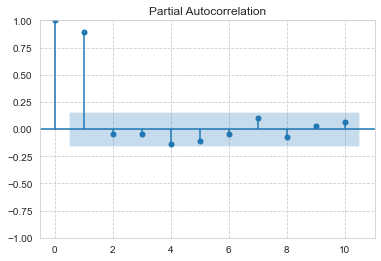

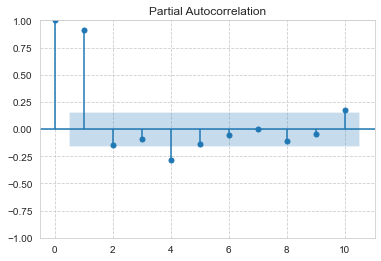

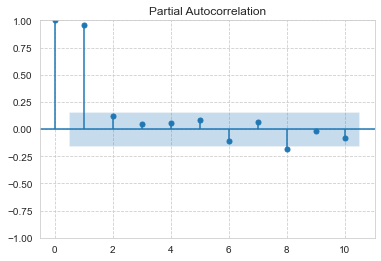

In [9]:
for k in range(K):
    _=plot_pacf(x=model.A[k, :], lags=10)

# Reconstruction / Regularizatioin / Objective
Study the RRO for different values of $\lambda$

In [10]:
dict_reco, dict_regu, dict_obj, dict_codings = cross_lambda_training(P=P_train, K=3, 
                                                        r_dim=11,
                                                        list_lambdas=[0.1, 1, 6, 10])

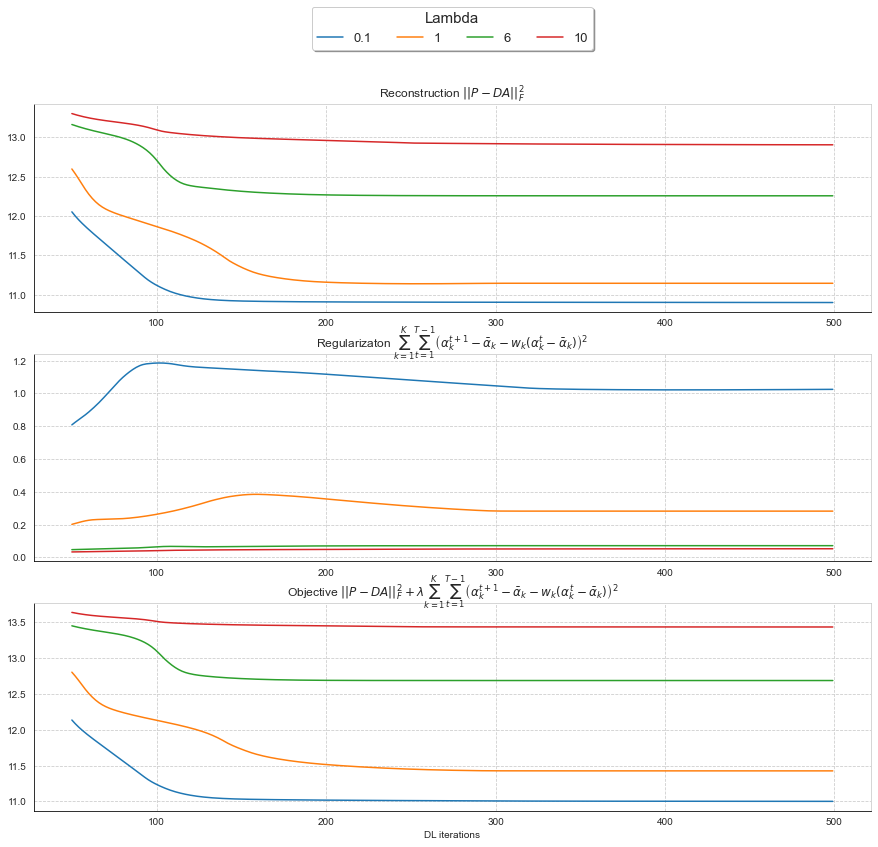

In [12]:
plot_rro(dict_reco, dict_regu, dict_obj, trunc=50)

### Codings

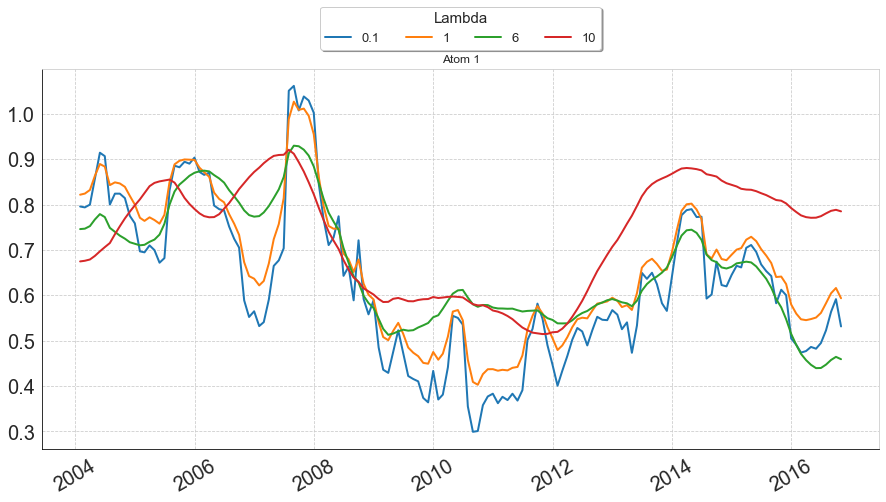

In [18]:
plot_codings_lamb(dict_codings, atom=1)

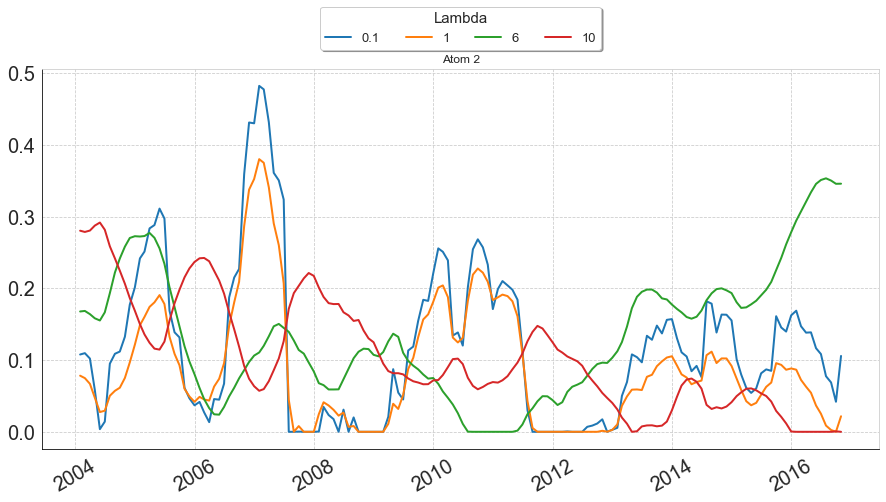

In [21]:
plot_codings_lamb(dict_codings, atom=2)

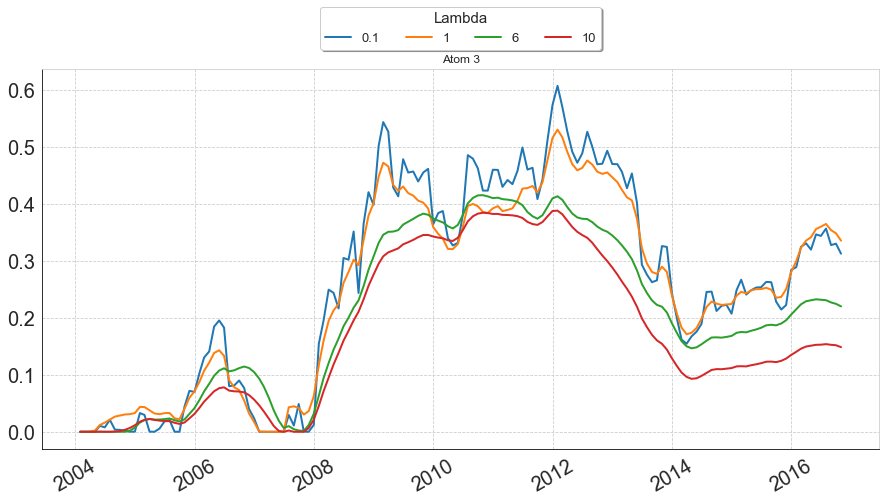

In [22]:
plot_codings_lamb(dict_codings, atom=3)

# Hyper-parameter selection

In [23]:
IFrame("imgs/hyperparameter_selection.pdf", width=600, height=600)

In [37]:
df_selection = model_selection(P_train, list_K=[3], 
                               list_lambdas=[0.01, 0.1, 1, 3, 5, 6, 7, 10], 
                               test_size=0.2)

In [38]:
df_selection.astype("float64").round(4)

,0.01,0.10,1.00,3.00,5.00,6.00,7.00,10.00
3,6.0877,5.151,4.7,4.6005,4.5848,4.5846,4.5847,4.5934


In [87]:
#df_selection.to_csv("ckpt/model_selection.csv")

# Dictionary

In [221]:
for atom in range(1, K+1):
    display(Latex("$d_{}$".format(atom)))
    display(pd.DataFrame(model.inv_vectorized(model.D[:, atom-1], 10, 11),
                        index=np.arange(1, 11), columns=np.arange(1, 12)).round(4)*100)

<IPython.core.display.Latex object>

,1,2,3,4,5,6,7,8,9,10,11
1,91.17,6.23,0.00,1.33,0.10,0.78,0.30,0.09,0.01,0.00,0.00
2,0.31,93.87,3.22,0.91,0.51,0.70,0.39,0.09,0.01,0.00,0.00
3,0.31,5.07,79.24,10.93,3.04,0.93,0.38,0.09,0.01,0.00,0.00
4,0.01,1.34,6.67,83.00,5.37,3.14,0.38,0.09,0.01,0.00,0.00
5,0.01,0.25,0.89,6.27,80.05,9.86,2.05,0.61,0.01,0.00,0.00
6,0.00,0.02,0.55,0.71,6.46,85.48,5.86,0.92,0.01,0.00,0.00
7,0.00,0.02,0.06,0.23,0.34,5.52,88.85,4.98,0.01,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.04,4.66,95.30,0.01,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,4.69,17.71,77.59,0.00,0.00
10,0.00,0.00,0.00,0.00,0.00,0.00,0.40,11.48,0.00,87.85,0.26


<IPython.core.display.Latex object>

,1,2,3,4,5,6,7,8,9,10,11
1,100.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,9.23,61.82,24.71,2.10,0.73,0.00,0.00,0.89,0.22,0.29,0.01
3,1.50,14.93,79.33,0.00,0.57,1.82,0.06,0.93,0.34,0.34,0.18
4,1.12,0.49,23.07,63.87,7.09,1.42,1.05,0.91,0.37,0.39,0.23
5,1.12,0.49,4.02,31.24,53.29,6.85,0.76,0.34,0.59,1.00,0.31
6,0.59,0.99,0.70,4.38,31.29,45.97,9.31,3.16,0.94,1.55,1.13
7,0.58,0.80,0.88,1.24,6.48,33.83,31.56,16.50,4.30,1.31,2.52
8,0.58,0.72,0.85,0.76,2.67,9.67,39.09,24.71,9.94,5.44,5.58
9,0.58,0.72,0.78,0.78,2.73,4.11,10.93,0.00,67.80,5.91,5.67
10,0.00,0.00,0.00,0.00,1.15,1.22,18.25,0.00,48.79,0.00,30.59


<IPython.core.display.Latex object>

,1,2,3,4,5,6,7,8,9,10,11
1,67.86,21.46,4.94,3.51,0.44,1.14,0.00,0.00,0.00,0.00,0.64
2,0.00,81.81,11.37,4.59,0.44,0.60,0.16,0.01,0.21,0.15,0.64
3,0.00,0.00,91.67,6.10,0.44,0.60,0.16,0.01,0.20,0.16,0.64
4,0.00,0.00,0.00,81.92,16.29,0.60,0.16,0.01,0.19,0.18,0.64
5,0.00,0.00,0.00,2.90,85.00,7.09,2.22,0.97,0.54,0.64,0.64
6,0.00,0.00,0.00,1.24,5.01,72.67,14.51,1.58,1.56,0.99,2.44
7,0.00,0.00,0.00,0.54,1.64,6.03,75.40,9.56,3.33,0.75,2.75
8,0.00,0.00,0.00,0.22,0.93,0.97,20.89,56.45,10.38,3.67,6.48
9,0.00,0.00,0.00,0.21,0.15,1.76,0.00,15.43,0.00,32.09,50.36
10,0.00,0.00,0.00,0.00,0.00,0.00,2.12,1.88,0.00,43.07,52.92


# Clustering (K-Means)

In [26]:
# Model
n_test = int(0.2 * N_MAT)
P_test = P[:, -int(n_test):]
n_train = int(N_MAT-n_test)
P_train = P[:, :int(N_MAT-n_test)]

K = 3
LAMB = 6

# build train model
model = DictionaryLearning(K=K, r_dim=11)
model.fit(P_train, lamb=LAMB, max_iter=500)

In [28]:
# Stadardization of training codings
A_mean = model.A.mean(axis=1).reshape(-1,1)
A_std = model.A.std(axis=1).reshape(-1,1)
A_scaled = ((model.A - A_mean) / A_std).T

In [30]:
N_CLUSTERS = 3
# Fit Kmean
kmeans = KMeans(
     init="random",
     n_clusters=N_CLUSTERS,
     n_init=10,
     max_iter=300,
     random_state=42)

kmeans.fit(A_scaled)

KMeans(init='random', n_clusters=3, random_state=42)

In [31]:
# Fit Kmean
kmeans = KMeans(
     init="random",
     n_clusters=N_CLUSTERS,
     n_init=10,
     max_iter=300,
     random_state=42)

kmeans.fit(A_scaled)

# Final locations of the centroids
kmeans.cluster_centers_

array([[-0.75387249, -0.76676297,  1.09959773],
       [ 1.20417419, -0.20252834, -1.00462648],
       [-0.35835011,  1.18692759, -0.294464  ]])

In [32]:
# Final predictions
y_train_pred = kmeans.labels_
y_train_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
      dtype=int32)

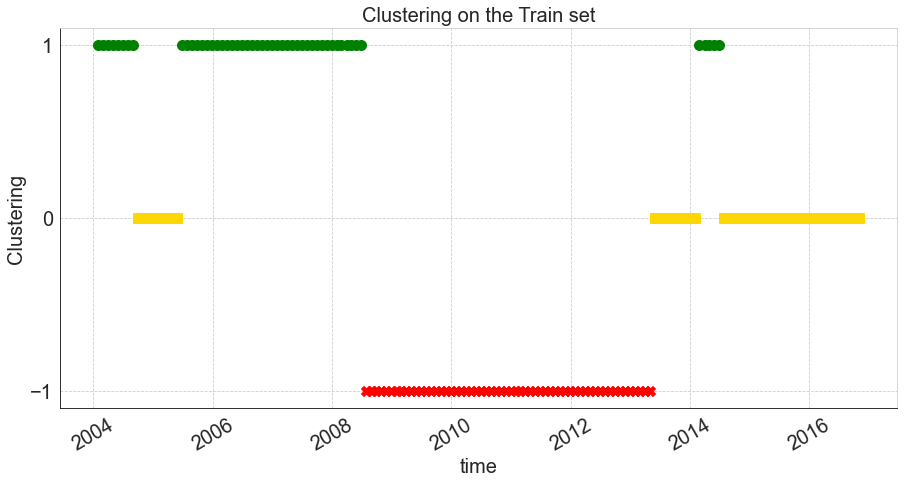

In [33]:
dict_labels={"green": 1, "gold":2, "red":0}


fig, ax = plt.subplots(1, 1, figsize=(15,7),)

ax.scatter(dates[:n_train][np.where(y_train_pred == dict_labels["red"])[0]], 
            -1*np.ones_like(np.where(y_train_pred == dict_labels["red"])[0]), 
            color="red", s=100, marker="X")

ax.scatter(dates[:n_train][np.where(y_train_pred == dict_labels["gold"])[0]], 
            np.zeros_like(np.where(y_train_pred == dict_labels["gold"])[0]), 
            color="gold", s=100, marker="s")

ax.scatter(dates[:n_train][np.where(y_train_pred == dict_labels["green"])[0]], 
            np.ones_like(np.where(y_train_pred == dict_labels["green"])[0]), 
            color="green", s=100, marker="o")

ax.spines["left"].set_color("black")
ax.spines["bottom"].set_color("black")

_=plt.xticks(fontsize=20, rotation=30)
_=plt.yticks(fontsize=20)

ax.set_yticks([-1, 0 , 1])

#print("Train")
#plt.savefig("imgs/clustering/cluster_train-K{}-lamb{}.eps".format(K, LAMB), format="eps")
plt.xlabel("time", fontsize=20)
plt.ylabel("Clustering", fontsize=20)
_ = plt.title("Clustering on the Train set", fontsize="20")

## Infer an economic sentiment indicator

**Plot the repartition of the clusters**

In [34]:
# labels associated with the red cluster
CLUSTER = "green"  # pick the color
cluster_times = np.where(y_train_pred == (dict_labels[CLUSTER]))[0]
cluster_times

array([  0,   1,   2,   3,   4,   5,   6,   7,  17,  18,  19,  20,  21,
        22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,
        35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,
        48,  49,  50,  51,  52,  53, 121, 122, 123, 124, 125])

In [35]:
# average the associated codings alpha
alpha_avg = model.A[:, cluster_times].mean(axis=1) #.round(1)
alpha_avg

array([0.81055832, 0.11639566, 0.06507055])

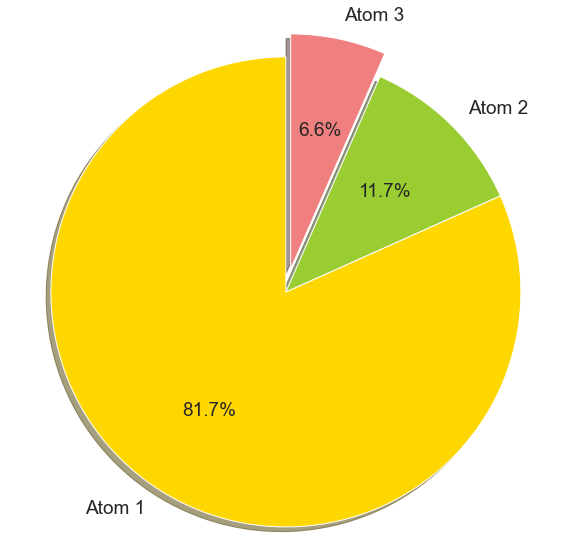

In [36]:
atoms = ["Atom {}".format(k) for k in np.arange(1, K+1)]
fig, ax = plt.subplots(figsize=(10, 10))
explode = (0, 0, 0.1)  # explode 1st slice
colors = ['gold', 'yellowgreen', 'lightcoral']

ax.pie(alpha_avg, labels=atoms, explode=explode, autopct='%.1f%%',
       colors=colors, shadow=True, startangle=90, textprops={'fontsize': 19}) # 

_=plt.axis('equal')
#plt.savefig("imgs/clustering/pie_train-group{}.eps".format(dict_labels["red"]), format="eps")